This python notebook is an implementation of Softmax Based Linear classifier on CIFAR_10 dataset.


In [0]:
import random
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#Data Preprocessing
This block downlaods the CIFAR_10 data from the source and divides it into test, train and development data. 

In [0]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset and perform preprocessing to prepare
    it for the linear classifier. 
    """ 
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train = X_train -  mean_image
    X_val = X_val -  mean_image
    X_test = X_test -  mean_image
    X_dev = X_dev -  mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train.T, y_train.T, X_val.T, y_val.T, X_test.T, y_test.T, X_dev.T, y_dev.T


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (3073, 49000)
Train labels shape:  (1, 49000)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1, 1000)
Test data shape:  (3073, 1000)
Test labels shape:  (1, 1000)
dev data shape:  (3073, 500)
dev labels shape:  (1, 500)


# Softmax Loss



In [0]:
def loss_grad_softmax_vectorized(W, X, y, reg):
    """ Compute the loss and gradients using softmax with vectorized version"""
    # Initialize parameters
    loss = 0 
    grad = np.zeros_like(W)
    dim, num_train = X.shape

    # Find the cost/ forward propagation step
    scores = W.dot(X) # [K, N]

    # Find loss
    scores -= np.max(scores)  #shift the scores so that maximum score is 0 to avoid explosion
    scores_exp = np.exp(scores)  
    correct_scores_exp = scores_exp[y, range(num_train)] # [N, ], 
    scores_exp_sum = np.sum(scores_exp, axis=0) # [N, ]
    loss = -np.sum(np.log(correct_scores_exp / scores_exp_sum))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    #Calculate gradient
    scores_exp_normalized = scores_exp / scores_exp_sum 
    scores_exp_normalized[y, range(num_train)] -= 1 # [K, N], deal with the correct class
    grad = scores_exp_normalized.dot(X.T) 
    grad /= num_train
    grad += reg * W

    return loss, grad

#Gradient Check
A function for checking the correctness of the gradient. (from CS231N Stanford course)

In [0]:
from __future__ import print_function
from random import randrange
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print (x.shape)

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    print (ix)
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [0]:
import time
W = np.random.randn(10, X_dev.shape[0]) * 0.001
tic = time.time()
loss_vec, grad_vect = loss_grad_softmax_vectorized(W, X_train, y_train, 0.0001)
toc = time.time()
print ('Vectorized loss: %f, and gradient: computed in %fs' % (loss_vec, toc - tic))

Vectorized loss: 5.117453, and gradient: computed in 0.958522s


In [0]:
f = lambda w: loss_grad_softmax_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(10, 3073)
(6, 488)
numerical: 0.761277 analytic: 0.761277, relative error: 7.862624e-08
(5, 1619)
numerical: 2.297275 analytic: 2.297275, relative error: 1.022044e-08
(5, 797)
numerical: 1.844144 analytic: 1.844144, relative error: 3.331413e-08
(1, 20)
numerical: 2.119766 analytic: 2.119766, relative error: 9.761431e-10
(8, 2329)
numerical: 0.518083 analytic: 0.518083, relative error: 7.375702e-08
(6, 2759)
numerical: 1.364609 analytic: 1.364609, relative error: 1.645071e-08
(9, 2996)
numerical: -1.964019 analytic: -1.964019, relative error: 6.820048e-10
(5, 2283)
numerical: 1.443787 analytic: 1.443787, relative error: 1.780552e-08
(5, 672)
numerical: 8.458393 analytic: 8.458393, relative error: 9.958499e-10
(4, 767)
numerical: 4.480525 analytic: 4.480525, relative error: 1.432928e-08


# Training

In [0]:
    def train(X, y, W, method='sgd', batch_size=200, learning_rate=1e-4,
              reg = 1e3, num_iters=1000, verbose=False, vectorized=True):
        """
        Train linear classifer using batch gradient descent or stochastic gradient descent
        Parameters
        ----------
        X: (D x N) array of training data, each column is a training sample with D-dimension.
        y: (N, ) 1-dimension array of target data with length N.
        method: (string) determine whether using 'bgd' or 'sgd'.
        batch_size: (integer) number of training examples to use at each step.
        learning_rate: (float) learning rate for optimization.
        reg: (float) regularization strength for optimization.
        num_iters: (integer) number of steps to take when optimization.
        verbose: (boolean) if True, print out the progress (loss) when optimization.
        Returns
        -------
        losses_history: (list) of losses at each training iteration
        """

        dim, num_train = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

        if W is None:
            # initialize the weights with small values
            if num_classes == 2: # just need weights for one class
                W = np.random.randn(1, dim) * 0.001
            else: # weigths for each class
                W = np.random.randn(num_classes, dim) * 0.001

        losses_history = []

        for i in range(num_iters):
            if method == 'bgd':
                loss, grad = loss_grad(X, y, reg, vectorized)
            else:
                # randomly choose a min-batch of samples
                idxs = np.random.choice(num_train, batch_size, replace=False)
                loss, grad = loss_grad_softmax_vectorized(W, X[:, idxs], y[:,idxs], reg) # grad => [K x D]
            losses_history.append(loss)

            # update weights
            W -= learning_rate * grad # [K x D]
            # print self.W
            # print 'dsfad', grad.shape
            if verbose and (i % 100 == 0):
                print ('iteration %d/%d: loss %f' % (i, num_iters, loss))

        return losses_history,W

In [0]:
    def predict(X,W):
        """
        Predict value of y using trained weights
        Parameters
        ----------
        X: (D x N) array of data, each column is a sample with D-dimension.
        Returns
        -------
        pred_ys: (N, ) 1-dimension array of y for N sampels
        h_x_mat: Normalized scores
        """
        pred_ys = np.zeros(X.shape[1])
        f_x_mat = W.dot(X)
        pred_ys = np.argmax(f_x_mat, axis=0)
        # normalized score
        h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
        h_x_mat = h_x_mat.squeeze()
        return pred_ys, h_x_mat

In [0]:
W = None
losses_sgd,W = train(X_train, y_train, W, method='sgd', batch_size=300, learning_rate=1e-7,
              reg = 3e5, num_iters=1000, verbose=True, vectorized=True)
toc = time.time()
print ('Traning time for SGD with vectorized version is %f \n' % (toc - tic))


y_val_pred_sgd = predict(X_val,W)[0]
print ('Validation accuracy: %f' % (np.mean(y_val == y_val_pred_sgd)))

iteration 0/1000: loss 4596.487737
iteration 100/1000: loss 12.563413
iteration 200/1000: loss 2.218601
iteration 300/1000: loss 2.205430
iteration 400/1000: loss 2.261921
iteration 500/1000: loss 2.209184
iteration 600/1000: loss 2.218080
iteration 700/1000: loss 2.213451
iteration 800/1000: loss 2.218881
iteration 900/1000: loss 2.226329
Traning time for SGD with vectorized version is 2165.487756 

Validation accuracy: 0.291000


# Visualtization

(10, 3072)


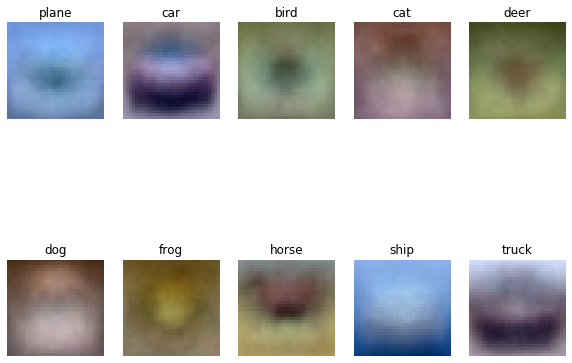

In [0]:
# Visualize the learned weights for each class
w = W[:,:-1] # strip out the bias
print(w.shape)
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])